# Quality control of switches using a checklist

In [2]:
# to show matplotlib images in the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from cv2.ximgproc import colorMatchTemplate  # for matching of all RGB channels at once, needs opencv-contrib-python
from cv2 import matchTemplate  # per channel match

## Set paths to data

In [3]:
# define paths to out dataset
TEST_DATA_PATH = os.path.join('..','test_data','switch')
TEST_DATA_PATH_OK = os.path.join(TEST_DATA_PATH,'ok')
TEST_DATA_PATH_FAIL = os.path.join(TEST_DATA_PATH,'fail')
TEST_DATA_PATH_TEST = os.path.join(TEST_DATA_PATH,'test')

## Define function for image alignment with template

In [4]:
def align_image(im1, im2, warp_mode=cv2.MOTION_EUCLIDEAN, max_iter=5000,\
                corr_inc_eps=1e-10, gauss_filt_size=5):
    """
    :param template_img: path to template image - image of an ideal case
    :param target_img: path to target image which is to be aligned with the template image
    :return: (correlation_coefficient (from -1 to 1), transformed image)
    """
    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iter, corr_inc_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.   
    try:
        (cc, warp_matrix) = cv2.findTransformECC(im1_gray,im2_gray,warp_matrix,\
                                                 warp_mode, criteria, None, gauss_filt_size)
        print('Image %s aligned! (correlation=%3.3f%%)' % (target.split(os.sep)[-1],cc*100.))
    except:
        print('Processing of %s failed!' % target)
        return 0., None

    #print("correlation: %3.2f%%" % (cc*100.))

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography 
        im2_aligned = cv2.warpPerspective(im2, warp_matrix, (im1.shape[1],im1.shape[0]),\
                                          flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP, borderValue=(255,255,255))
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (im1.shape[1],im1.shape[0]),\
                                     flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP, borderValue=(255,255,255))
        
    return cc, im2_aligned

## Define similarity measure (per channel)

In [297]:
def match_images(im1, im2):
    """
    :param im1: template image
    :param im2: tegre image which we match to template
    :return: return matrix of metrics for each image position
    
    The smaller value, the better similarity between images, it is per pixel comparison.
    """
    #result = colorMatchTemplate(im1, im2)
    
    # All possible measures of similarity:
    #TM_SQDIFF, TM_SQDIFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_CCOEFF, TM_CCOEFF_NORMED
    result = matchTemplate(im1,im2,cv2.TM_CCOEFF_NORMED) 
    
    return result

## Define checklist and show it on the template

In [6]:
import matplotlib.patches as patches

In [7]:
# define bounding box color for various cases
NOT_CLASSIFIED_COLOR = 'b'  # color of bounding box when not classified
CLASSIFIED_OK_COLOR = 'g'  # if checklist item classified as OK
CLASSIFIED_FAIL_COLOR = 'r'  # if checklist item classified as FAIL

def show_checklist_items(ax, checklist, classification={}):
    """
    :param ax: matplotlib image axes
    :param checklist: dict with items to check and their bounding boxes
    :classification: optional dict with keys same as in :param checklist: and colors as values
    """
    for k,v in checklist.items():
        # get coordinates
        x1,x2,y1,y2 = v
        # get classification result (color for now)
        color = classification.get(k, NOT_CLASSIFIED_COLOR)
        # prepere bounding box
        rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=3,edgecolor=color,facecolor='none')    
        # put it to axes
        ax.add_patch(rect)

In [8]:
# following check list has to be be clicked by a user... in some GUI... whatever...
checklist = {'upper left corner':  (120,160,40,80),
             'upper right corner': (430,470,40,80),
             'lower left corner':  (120,160,340,380),
             'lower right corner': (430,470,340,380),
             'trimmer':            (200,260,160,220),
             'connector':          (162,200,100,172)}

### Example of checklist displayed on the template

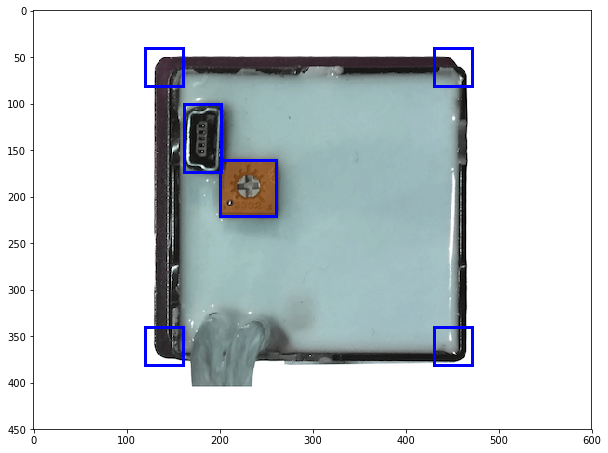

In [9]:
template_img = cv2.imread(os.path.join(TEST_DATA_PATH_OK,'switch-0-ok.png'))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(template_img)
show_checklist_items(ax, checklist)

### Extract fatures for learnig classifiers for all items

1. Align target image to template
2. Select items to check from aligned target according to bounding boxes given by operator
3. Save all features to vertors along with their classification!
4. Pass this data to training stage

In [165]:
def process_target(template, target, plot=False, return_aligned=False):
    # read image
    template_img = cv2.imread(template)
    target_img = cv2.imread(target)
    # align image with out template (which we consider perfect), yields correlation coeff. and aligned image
    cc, target_img_align = align_image(template_img, target_img, warp_mode=cv2.MOTION_HOMOGRAPHY)    
    # convert to HSV space
    #target_img_rot_HSV = cv2.cvtColor(target_img_rot, cv2.COLOR_BGR2HSV)    
    # split HSV channels
    #target_img_rot_H, target_img_rot_S, target_img_rot_V = cv2.split(target_img_rot_HSV
        
    if target_img_align is None:  # aligment failed
        max_float = np.finfo(np.float32).max  # some large number to raise alarm
        return max_float, max_float, max_float
    else:
        if plot: fig = plt.figure(figsize=(10,3))   

        
        B_check = {}
        G_check = {}
        R_check = {}
        
        H_check = {}
        S_check = {}
        V_check = {}
        
        for i,(k,v) in enumerate(checklist.items()):
            # get bounding box coordinates
            x1,x2,y1,y2 = v

            # extract sub-images in bounding boxes
            item_target_align = target_img_align[y1:y2+1,x1:x2+1]
            item_template = template_img[y1:y2+1,x1:x2+1]

            item_target_align_B, item_target_align_G, item_target_align_R = cv2.split(item_target_align)
            item_template_B, item_template_G, item_template_R = cv2.split(item_template)
            
            # convert to HSV space
            item_target_align_HSV = cv2.cvtColor(item_target_align, cv2.COLOR_BGR2HSV)
            item_target_align_H, item_target_align_S, item_target_align_V = cv2.split(item_target_align_HSV)

            # split HSV channels        
            item_template_HSV = cv2.cvtColor(item_template, cv2.COLOR_BGR2HSV)        
            item_template_H, item_template_S, item_template_V = cv2.split(item_template_HSV)

            if plot:
                ax = fig.add_subplot(2,len(checklist),i+1)
                ax.imshow(item_template)
                ax.set_title('Temp.')

                ax = fig.add_subplot(2,len(checklist),i+1+len(checklist))
                ax.imshow(item_target_align)
                ax.set_title('Targ.')

            # score each HSV channels agains template channels    
            H_check[k] = match_images(item_template_H, item_target_align_H)
            S_check[k] = match_images(item_template_S, item_target_align_S)
            V_check[k] = match_images(item_template_V, item_target_align_V) 

            # score each HSV channels agains template channels    
            B_check[k] = match_images(item_template_B, item_target_align_B)
            G_check[k] = match_images(item_template_G, item_target_align_G)
            R_check[k] = match_images(item_template_R, item_target_align_R) 
            
            
            print('Checking item %40s... H: %3.2f S: %3.2f V: %3.2f B: %3.2f G: %3.2f R: %3.2f' %\
                  (k, H_check[k], S_check[k], V_check[k], B_check[k], G_check[k], R_check[k]))

        if plot: 
            plt.tight_layout()
            plt.show()

        print('-'*60)

        if return_aligned:
            return H_check, S_check, V_check, B_check, G_check, R_check, target_img_align
        else:
            return H_check, S_check, V_check, B_check, G_check, R_check

## Preparation for training

### Put everything together and compute differences of targets and the template

Processing "../test_data/switch/ok/switch-0-ok.png", be patient...
Image switch-0-ok.png aligned! (correlation=100.000%)
Checking item                                connector... H: 1.00 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                                  trimmer... H: 1.00 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       lower right corner... H: 1.00 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 1.00 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 1.00 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 1.00 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00


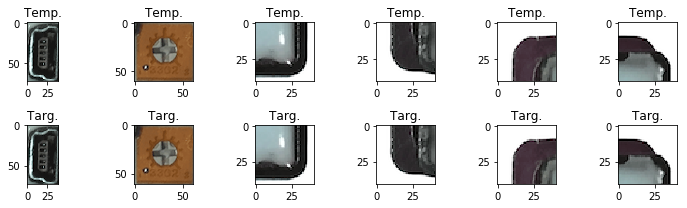

------------------------------------------------------------
Processing "../test_data/switch/ok/switch-1-ok.png", be patient...
Image switch-1-ok.png aligned! (correlation=99.867%)
Checking item                                connector... H: 0.77 S: 0.50 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                                  trimmer... H: 0.86 S: 0.99 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       lower right corner... H: 0.77 S: 0.62 V: 1.00 B: 0.99 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.93 S: 0.54 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.95 S: 0.86 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.88 S: 0.82 V: 1.00 B: 1.00 G: 1.00 R: 1.00


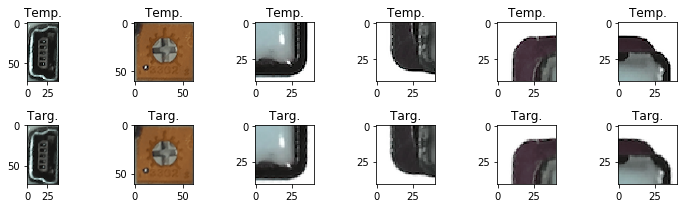

------------------------------------------------------------
Processing "../test_data/switch/ok/switch-2-ok.png", be patient...
Image switch-2-ok.png aligned! (correlation=99.872%)
Checking item                                connector... H: 0.75 S: 0.44 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                                  trimmer... H: 0.86 S: 0.99 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       lower right corner... H: 0.79 S: 0.60 V: 1.00 B: 0.99 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.90 S: 0.39 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.95 S: 0.88 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.89 S: 0.83 V: 1.00 B: 1.00 G: 1.00 R: 1.00


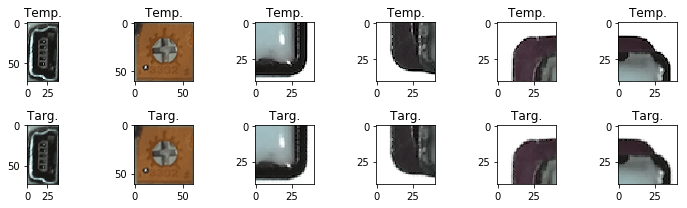

------------------------------------------------------------
Processing "../test_data/switch/ok/switch-3-ok.png", be patient...
Image switch-3-ok.png aligned! (correlation=99.867%)
Checking item                                connector... H: 0.76 S: 0.49 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                                  trimmer... H: 0.87 S: 0.99 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       lower right corner... H: 0.73 S: 0.61 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.91 S: 0.49 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.95 S: 0.85 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.88 S: 0.78 V: 1.00 B: 1.00 G: 1.00 R: 1.00


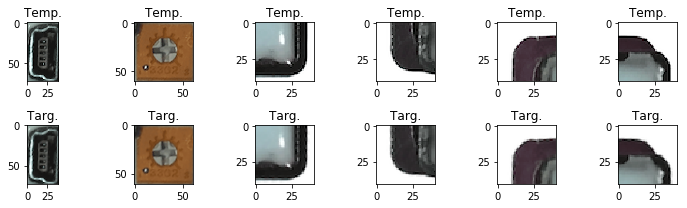

------------------------------------------------------------
Processing "../test_data/switch/ok/switch-4-ok.png", be patient...
Image switch-4-ok.png aligned! (correlation=99.866%)
Checking item                                connector... H: 0.74 S: 0.40 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                                  trimmer... H: 0.85 S: 0.99 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       lower right corner... H: 0.77 S: 0.51 V: 1.00 B: 0.99 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.91 S: 0.44 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.95 S: 0.86 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.87 S: 0.84 V: 1.00 B: 1.00 G: 1.00 R: 1.00


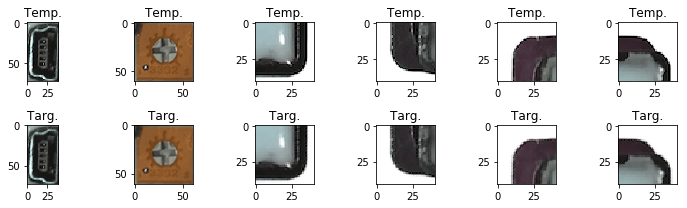

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-0-fail.png", be patient...
Image switch-0-fail.png aligned! (correlation=98.147%)
Checking item                                connector... H: 0.70 S: 0.39 V: 0.98 B: 0.98 G: 0.98 R: 0.98
Checking item                                  trimmer... H: -0.12 S: 0.24 V: 0.57 B: 0.56 G: 0.34 R: 0.05
Checking item                       lower right corner... H: 0.73 S: 0.58 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.90 S: 0.47 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.94 S: 0.85 V: 0.99 B: 0.99 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.88 S: 0.82 V: 0.99 B: 0.99 G: 1.00 R: 0.99


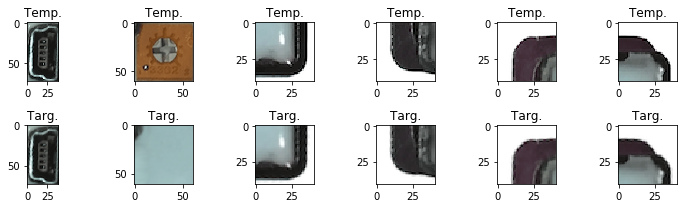

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-1-fail.png", be patient...
Image switch-1-fail.png aligned! (correlation=99.922%)
Checking item                                connector... H: 0.61 S: 0.44 V: 0.93 B: 0.92 G: 0.93 R: 0.94
Checking item                                  trimmer... H: 0.85 S: 0.99 V: 0.99 B: 0.99 G: 0.98 R: 0.99
Checking item                       lower right corner... H: 0.72 S: 0.58 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.92 S: 0.41 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.94 S: 0.85 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       upper right corner... H: 0.88 S: 0.83 V: 0.99 B: 0.99 G: 0.99 R: 0.99


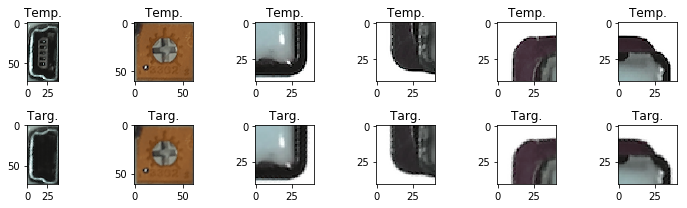

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-10-fail.png", be patient...
Image switch-10-fail.png aligned! (correlation=99.294%)
Checking item                                connector... H: 0.71 S: 0.44 V: 0.98 B: 0.98 G: 0.98 R: 0.98
Checking item                                  trimmer... H: 0.82 S: 0.99 V: 0.98 B: 0.98 G: 0.97 R: 0.98
Checking item                       lower right corner... H: 0.69 S: 0.54 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.51 S: 0.23 V: 0.61 B: 0.61 G: 0.61 R: 0.61
Checking item                        upper left corner... H: 0.94 S: 0.83 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       upper right corner... H: 0.87 S: 0.82 V: 0.99 B: 0.99 G: 0.99 R: 0.99


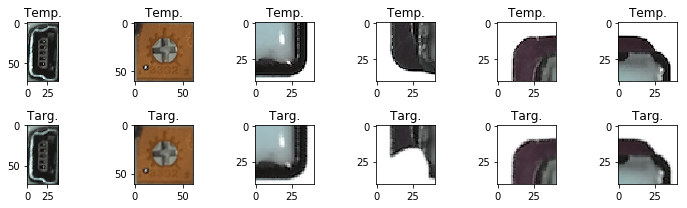

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-11-fail.png", be patient...
Image switch-11-fail.png aligned! (correlation=95.410%)
Checking item                                connector... H: -0.00 S: 0.04 V: -0.08 B: -0.04 G: -0.07 R: -0.09
Checking item                                  trimmer... H: -0.01 S: 0.03 V: 0.14 B: 0.06 G: -0.07 R: -0.11
Checking item                       lower right corner... H: 0.97 S: 0.92 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.98 S: 0.86 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.98 S: 0.92 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.99 S: 0.95 V: 1.00 B: 1.00 G: 1.00 R: 1.00


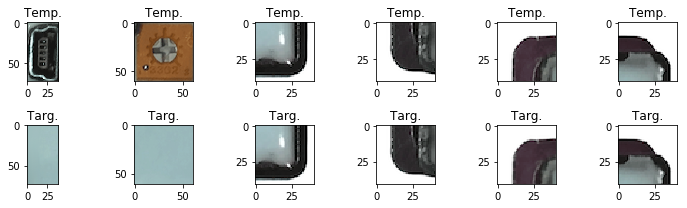

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-2-fail.png", be patient...
Image switch-2-fail.png aligned! (correlation=99.848%)
Checking item                                connector... H: 0.71 S: 0.41 V: 0.98 B: 0.98 G: 0.98 R: 0.98
Checking item                                  trimmer... H: 0.78 S: 0.98 V: 0.69 B: 0.70 G: 0.24 R: 0.49
Checking item                       lower right corner... H: 0.74 S: 0.47 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.91 S: 0.46 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.95 S: 0.86 V: 0.99 B: 0.99 G: 1.00 R: 0.99
Checking item                       upper right corner... H: 0.86 S: 0.80 V: 0.99 B: 0.99 G: 0.99 R: 0.99


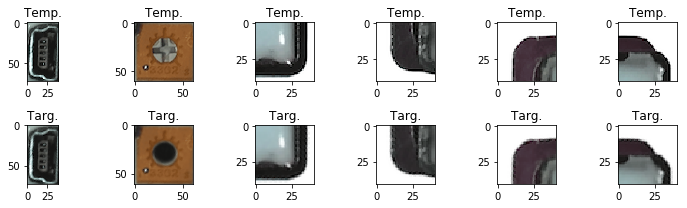

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-3-fail.png", be patient...
Image switch-3-fail.png aligned! (correlation=98.007%)
Checking item                                connector... H: 0.03 S: -0.04 V: 0.14 B: 0.20 G: 0.14 R: 0.14
Checking item                                  trimmer... H: 0.60 S: 0.98 V: 0.72 B: 0.81 G: 0.67 R: 0.84
Checking item                       lower right corner... H: 0.73 S: 0.50 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.90 S: 0.37 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.94 S: 0.86 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                       upper right corner... H: 0.85 S: 0.82 V: 0.99 B: 0.99 G: 0.99 R: 0.99


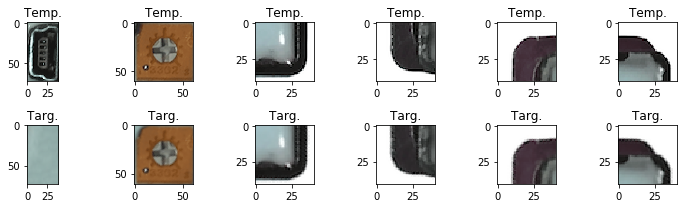

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-4-fail.png", be patient...
Image switch-4-fail.png aligned! (correlation=99.935%)
Checking item                                connector... H: 0.69 S: 0.38 V: 0.98 B: 0.98 G: 0.98 R: 0.98
Checking item                                  trimmer... H: 0.65 S: 0.64 V: 0.72 B: 0.72 G: 0.68 R: 0.65
Checking item                       lower right corner... H: 0.74 S: 0.57 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.90 S: 0.46 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.94 S: 0.87 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.86 S: 0.80 V: 0.99 B: 0.99 G: 0.99 R: 0.99


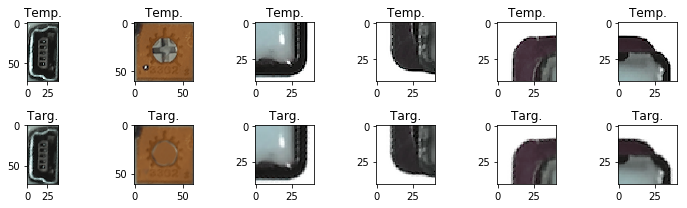

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-6-fail.png", be patient...
Image switch-6-fail.png aligned! (correlation=99.879%)
Checking item                                connector... H: 0.72 S: 0.43 V: 0.99 B: 0.98 G: 0.99 R: 0.99
Checking item                                  trimmer... H: 0.29 S: 0.76 V: 0.95 B: 0.96 G: 0.72 R: 0.62
Checking item                       lower right corner... H: 0.75 S: 0.53 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.90 S: 0.43 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.94 S: 0.86 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.88 S: 0.82 V: 0.99 B: 1.00 G: 1.00 R: 1.00


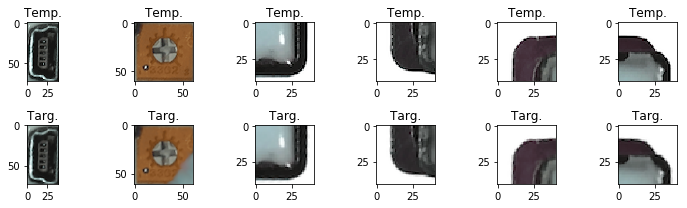

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-7-fail.png", be patient...
Image switch-7-fail.png aligned! (correlation=98.287%)
Checking item                                connector... H: 0.71 S: 0.44 V: 0.98 B: 0.98 G: 0.98 R: 0.98
Checking item                                  trimmer... H: 0.85 S: 0.99 V: 0.99 B: 0.99 G: 0.98 R: 0.99
Checking item                       lower right corner... H: -0.02 S: 0.15 V: 0.06 B: 0.06 G: 0.06 R: 0.06
Checking item                        lower left corner... H: 0.89 S: 0.39 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.94 S: 0.84 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.88 S: 0.84 V: 0.99 B: 0.99 G: 0.99 R: 0.99


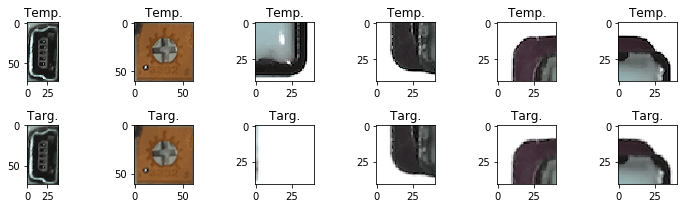

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-8-fail.png", be patient...
Image switch-8-fail.png aligned! (correlation=98.939%)
Checking item                                connector... H: 0.72 S: 0.44 V: 0.98 B: 0.98 G: 0.98 R: 0.98
Checking item                                  trimmer... H: 0.86 S: 0.99 V: 0.98 B: 0.98 G: 0.98 R: 0.99
Checking item                       lower right corner... H: 0.73 S: 0.53 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.89 S: 0.45 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        upper left corner... H: 0.44 S: 0.40 V: 0.44 B: 0.44 G: 0.44 R: 0.44
Checking item                       upper right corner... H: 0.86 S: 0.79 V: 0.99 B: 0.99 G: 0.99 R: 0.99


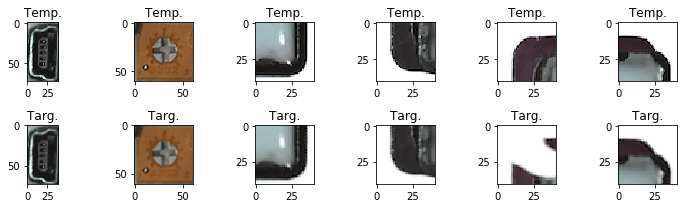

------------------------------------------------------------
Processing "../test_data/switch/fail/switch-9-fail.png", be patient...
Image switch-9-fail.png aligned! (correlation=99.325%)
Checking item                                connector... H: 0.75 S: 0.45 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                                  trimmer... H: 0.84 S: 0.99 V: 0.99 B: 0.99 G: 0.98 R: 0.99
Checking item                       lower right corner... H: 0.76 S: 0.48 V: 0.99 B: 0.99 G: 0.99 R: 0.99
Checking item                        lower left corner... H: 0.89 S: 0.56 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.96 S: 0.85 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.57 S: 0.50 V: 0.61 B: 0.59 G: 0.61 R: 0.61


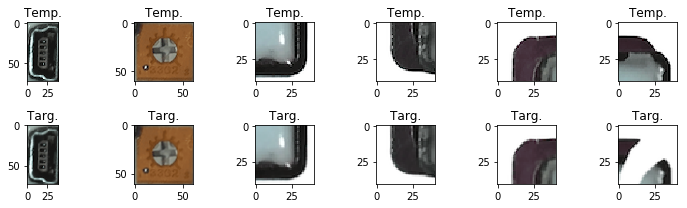

------------------------------------------------------------
DONE!


In [300]:
# all OK samples
images_oks = sorted([os.path.join(TEST_DATA_PATH_OK,x) for x in filter(lambda x: x.endswith('png'),\
                                                                       os.listdir(TEST_DATA_PATH_OK))])
# all samples of failure
images_fails = sorted([os.path.join(TEST_DATA_PATH_FAIL,x) for x in filter(lambda x: x.endswith('png'),\
                                                                           os.listdir(TEST_DATA_PATH_FAIL))])

images_all = images_oks + images_fails

overall_labels_Y = np.array([1]*len(images_oks)+[0]*len(images_fails))

THRESHOLD = 0.98

# source image - template to which we match everything
template = os.path.join(TEST_DATA_PATH_OK,'switch-0-ok.png')

# just for statistics and later evaluation...
H_points = []
S_points = []
V_points = []

B_points = []
G_points = []
R_points = []

aligned_targets = []

# loop over all images in out dataset
for target in images_all:
    print('Processing "%s", be patient...' % target)
    H, S, V, B, G, R, target_img_align = process_target(template, target, plot=True, return_aligned=True)
    
    # store results for later...
    H_points.append(H)
    S_points.append(S)
    V_points.append(V)    
    B_points.append(B)
    G_points.append(G)
    R_points.append(R)
    
    # store aligned images
    aligned_targets.append(target_img_align)

aligned_targets = np.array(aligned_targets)
print('DONE!')

In [167]:
# save aligned targes to file for posibble later use 
np.save('aligned_targets',aligned_targets)
%ls

aligned_targets.npy              labels_lower left corner.npy
features_connector.npy           labels_lower right corner.npy
features_lower left corner.npy   labels_trimmer.npy
features_lower right corner.npy  labels_upper left corner.npy
features_trimmer.npy             labels_upper right corner.npy
features_upper left corner.npy   switch_detector.ipynb
features_upper right corner.npy  switch_detector_component.ipynb
labels_connector.npy             test_aligned_images.npy


### Rotation check on failure cases

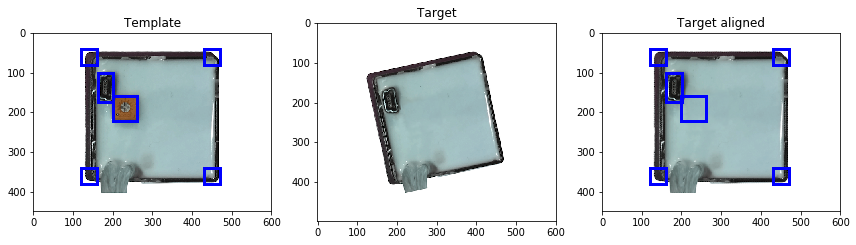

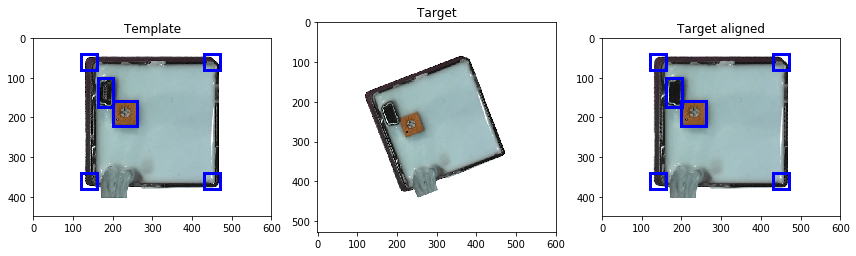

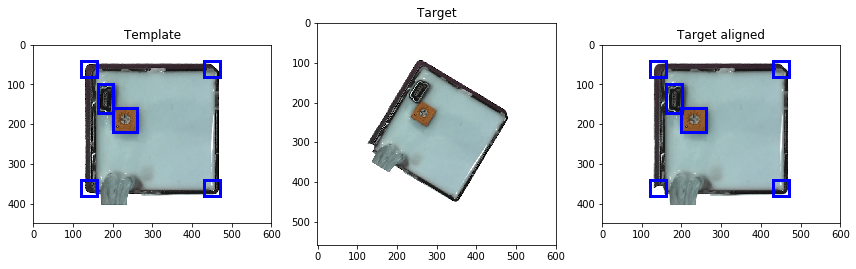

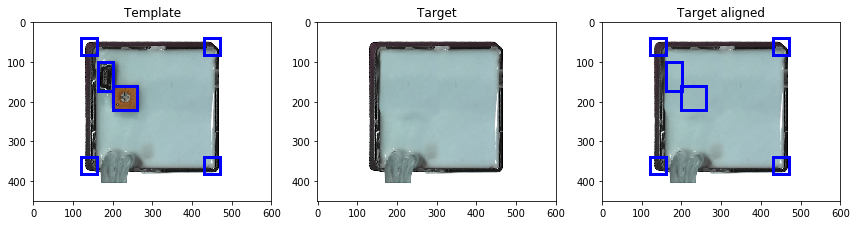

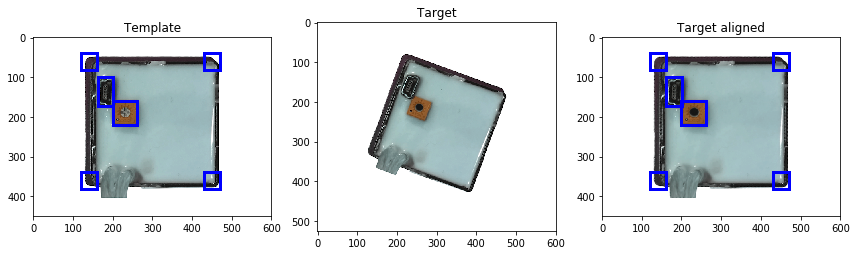

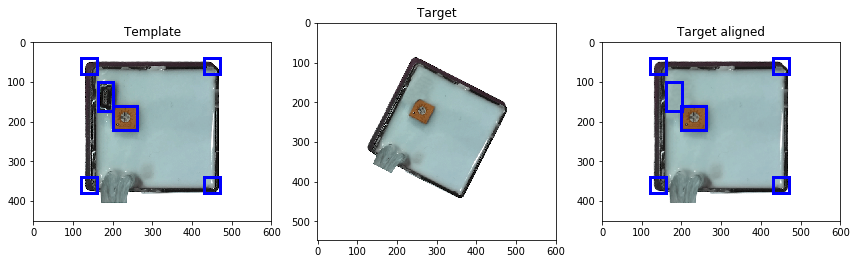

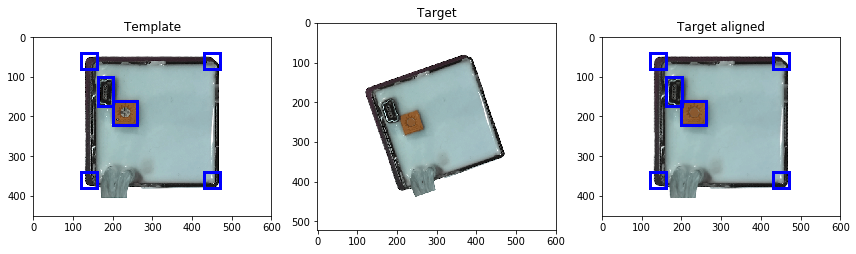

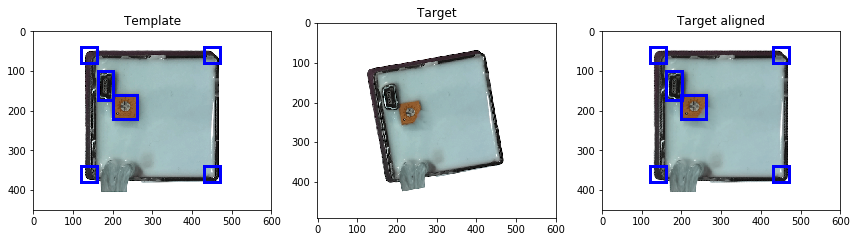

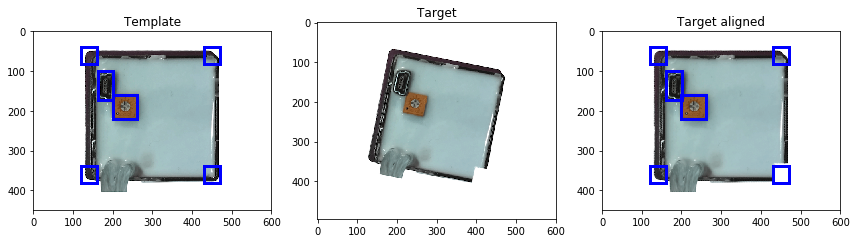

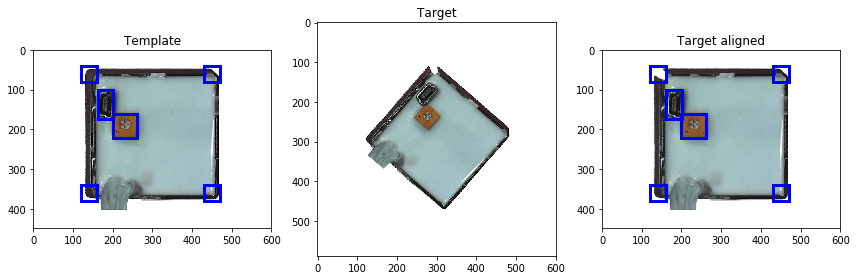

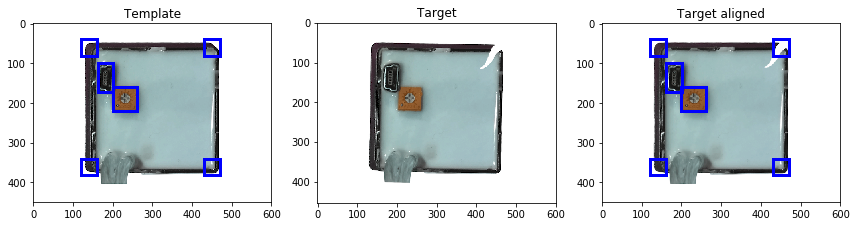

In [365]:
template_img = cv2.imread(os.path.join(TEST_DATA_PATH_OK,'switch-0-ok.png'))

for i, image_ in enumerate(images_fails):
    target = cv2.imread(image_)
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(131)
    show_checklist_items(ax, checklist)
    ax.imshow(template_img)
    ax.set_title('Template')
    ax = fig.add_subplot(132)
    ax.imshow(target)
    ax.set_title('Target')    
    ax = fig.add_subplot(133)
    ax.imshow(aligned_targets[5+i])
    show_checklist_items(ax, checklist)
    ax.set_title('Target aligned')    
    plt.tight_layout()

### Preparation of features

In [301]:
features = {}
for k,v in checklist.items():
    # first len(images_oks) are ok in all aspects
    features[k] = []

for k,v in checklist.items():
    # first len(images_oks) are ok in all aspects
    for H,S,V,B,G,R in zip(H_points, S_points, V_points, B_points, G_points, R_points):
        features[k].append([H[k][0][0],S[k][0][0],V[k][0][0],B[k][0][0],G[k][0][0],R[k][0][0]])
    
#pprint.pprint(features)

In [302]:
for k,v in features.items():
    np.save('features_HSVBGR_TCORFFNORM_%s' % k, np.array(v))
%ls

aligned_targets.npy
features_BGR_connector.npy
features_BGR_lower left corner.npy
features_BGR_lower right corner.npy
features_BGR_trimmer.npy
features_BGR_upper left corner.npy
features_BGR_upper right corner.npy
features_HSBGR_connector.npy
features_HSBGR_lower left corner.npy
features_HSBGR_lower right corner.npy
features_HSBGR_trimmer.npy
features_HSBGR_upper left corner.npy
features_HSBGR_upper right corner.npy
features_HSVBGR_TCORFFNORM_connector.npy
features_HSVBGR_TCORFFNORM_lower left corner.npy
features_HSVBGR_TCORFFNORM_lower right corner.npy
features_HSVBGR_TCORFFNORM_trimmer.npy
features_HSVBGR_TCORFFNORM_upper left corner.npy
features_HSVBGR_TCORFFNORM_upper right corner.npy
features_HSVBGR_connector.npy
features_HSVBGR_lower left corner.npy
features_HSVBGR_lower right corner.npy
features_HSVBGR_trimmer.npy
features_HSVBGR_upper left corner.npy
features_HSVBGR_upper right corner.npy
features_connector.npy
features_lower left corner.npy
features_lower right corner.npy
feat

### Preparation of labels - what is correct on each training example

In [303]:
# initialize labels for each classification sub-task
labels = {}

for k,v in checklist.items():
    # first len(images_oks) are ok in all aspects
    labels[k] = [1]*len(images_oks)
    
labels['connector']          += [1,0,1,0,1,0,1,1,1,1,1]
labels['lower left corner']  += [1,1,0,1,1,1,1,1,1,1,1]
labels['lower right corner'] += [1,1,1,1,1,1,1,1,0,1,1]
labels['trimmer']            += [0,1,1,0,0,1,0,0,1,1,1]
labels['upper left corner']  += [1,1,1,1,1,1,1,1,1,0,1]
labels['upper right corner'] += [1,1,1,1,1,1,1,1,1,1,0]

import pprint
pprint.pprint(labels)
for k,v in labels.items():
    np.save('labels_%s' % k, np.array(v))
%ls

{'connector': [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
 'lower left corner': [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 'lower right corner': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
 'trimmer': [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1],
 'upper left corner': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 'upper right corner': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}
aligned_targets.npy
features_BGR_connector.npy
features_BGR_lower left corner.npy
features_BGR_lower right corner.npy
features_BGR_trimmer.npy
features_BGR_upper left corner.npy
features_BGR_upper right corner.npy
features_HSBGR_connector.npy
features_HSBGR_lower left corner.npy
features_HSBGR_lower right corner.npy
features_HSBGR_trimmer.npy
features_HSBGR_upper left corner.npy
features_HSBGR_upper right corner.npy
features_HSVBGR_TCORFFNORM_connector.npy
features_HSVBGR_TCORFFNORM_lower left corner.npy
features_HSVBGR_TCORFFNORM_lower right corner.npy
features_HSVBGR_TCORFFNO

## Training of classifiers

* let's try some classifiers from sklear
* https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

#### Naive Bayes

In [304]:
from sklearn.naive_bayes import GaussianNB

classifiers_NB = {}

for k in features.keys():
    clf = GaussianNB()
    clf.fit(features[k][:], labels[k][:])
    classifiers_NB[k] = clf

#### Linear SVM

In [305]:
from sklearn.svm import SVC

classifiers_LSVM = {}
for k in features.keys():
    clf = SVC(kernel="linear", C=0.025)
    clf.fit(features[k][:], labels[k][:])
    classifiers_LSVM[k] = clf

#### SVM

In [306]:
from sklearn.svm import SVC

classifiers_SVM = {}
for k in features.keys():
    clf = SVC(gamma=2, C=1)
    clf.fit(features[k][:], labels[k][:])
    classifiers_SVM[k] = clf

#### Decision tree

In [307]:
from sklearn.tree import DecisionTreeClassifier

classifiers_DTREE = {}
for k in features.keys():
    clf = DecisionTreeClassifier(max_depth=15)
    clf.fit(features[k][:], labels[k][:])  
    classifiers_DTREE[k] = clf

#### Random forest

In [318]:
from sklearn.ensemble import RandomForestClassifier

classifiers_RANFOR = {}
for k in features.keys():
    clf = RandomForestClassifier(max_depth=15, n_estimators=30, max_features=6)
    clf.fit(features[k][:], labels[k][:])
    classifiers_RANFOR[k] = clf

#### One-class SVM

In [309]:
from sklearn.svm import OneClassSVM
classifiers_ONEC_SVM = {}
for k in features.keys():
    clf = OneClassSVM(gamma='auto').fit([x for x,y in zip(features[k][1:],labels[k][1:]) if y==1])
    classifiers_ONEC_SVM[k] = clf
    

#### Isolation forest

In [310]:
from sklearn.ensemble import IsolationForest
classifiers_ISOFOR = {}
for k in features.keys():
    clf = IsolationForest(contamination=0.01, behaviour='new').fit([x for x,y in zip(features[k][:],labels[k][:]) if y==1])
    classifiers_ISOFOR[k] = clf


#### kNN

In [337]:
from sklearn.neighbors import KNeighborsClassifier
classifiers_kNN = {}
for k in features.keys():
    clf = KNeighborsClassifier(5)
    clf.fit(features[k][:],labels[k][:])
    classifiers_kNN[k] = clf

#### Gaussian Process

In [342]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

classifiers_GP = {}
for k in features.keys():
    clf = GaussianProcessClassifier(1.0 * RBF(1.0))
    clf.fit(features[k][:],labels[k][:])
    classifiers_GP[k] = clf


#### MLP

In [345]:
from sklearn.neural_network import MLPClassifier

classifiers_MLP = {}
for k in features.keys():
    clf = MLPClassifier(alpha=1, max_iter=1000)
    clf.fit(features[k][:],labels[k][:])
    classifiers_MLP[k] = clf

#### ADA Boost

In [354]:
from sklearn.ensemble import AdaBoostClassifier

classifiers_ADA = {}
for k in features.keys():
    clf = AdaBoostClassifier()
    clf.fit(features[k][:],labels[k][:])
    classifiers_ADA[k] = clf

## Let's test in on new examples

In [43]:
images_test = sorted([os.path.join(TEST_DATA_PATH_TEST,x) for x in filter(lambda x: x.endswith('png'), os.listdir(TEST_DATA_PATH_TEST))])

In [44]:
images_test

['../test_data/switch/test/switch-12-fail.png',
 '../test_data/switch/test/switch-13-fail.png',
 '../test_data/switch/test/switch-14-fail.png',
 '../test_data/switch/test/switch-15-fail.png']

#### Vectors of true test labels

In [254]:
true_test_labels = {}
true_test_labels['connector']          = [1,1,1,1]
true_test_labels['lower left corner']  = [1,1,1,1]
true_test_labels['lower right corner'] = [1,1,1,0]
true_test_labels['trimmer']            = [0,0,1,1]
true_test_labels['upper left corner']  = [1,1,1,1]
true_test_labels['upper right corner'] = [1,1,1,1]
pprint.pprint(true_test_labels)

{'connector': [1, 1, 1, 1],
 'lower left corner': [1, 1, 1, 1],
 'lower right corner': [1, 1, 1, 0],
 'trimmer': [0, 0, 1, 1],
 'upper left corner': [1, 1, 1, 1],
 'upper right corner': [1, 1, 1, 1]}


#### Get test features

Processing "../test_data/switch/test/switch-12-fail.png", be patient...
Image switch-12-fail.png aligned! (correlation=99.305%)
Checking item                                connector... H: 0.94 S: 0.89 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                                  trimmer... H: 0.11 S: 0.56 V: 0.65 B: 0.83 G: 0.28 R: 0.19
Checking item                       lower right corner... H: 0.96 S: 0.87 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.97 S: 0.81 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.97 S: 0.97 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.97 S: 0.92 V: 1.00 B: 1.00 G: 1.00 R: 1.00


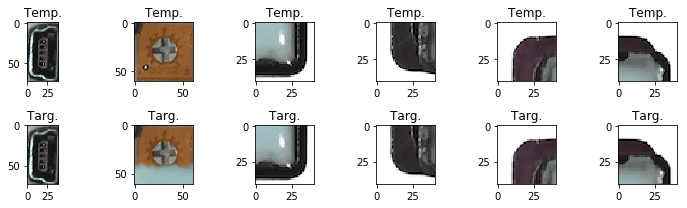

------------------------------------------------------------
Processing "../test_data/switch/test/switch-13-fail.png", be patient...
Image switch-13-fail.png aligned! (correlation=99.842%)
Checking item                                connector... H: 0.98 S: 0.98 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                                  trimmer... H: 0.22 S: 0.70 V: 0.44 B: 0.50 G: 0.28 R: 0.46
Checking item                       lower right corner... H: 0.99 S: 0.98 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.99 S: 0.91 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.99 S: 0.95 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.99 S: 0.87 V: 1.00 B: 1.00 G: 1.00 R: 1.00


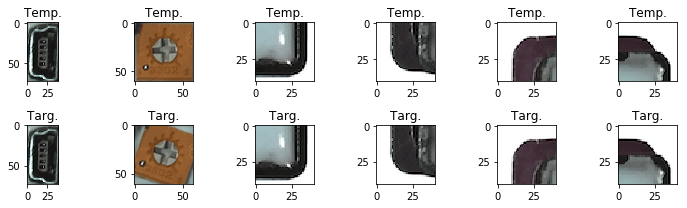

------------------------------------------------------------
Processing "../test_data/switch/test/switch-14-fail.png", be patient...
Image switch-14-fail.png aligned! (correlation=95.529%)
Checking item                                connector... H: 0.75 S: 0.39 V: 0.90 B: 0.89 G: 0.90 R: 0.90
Checking item                                  trimmer... H: 0.77 S: 0.96 V: 0.91 B: 0.91 G: 0.87 R: 0.92
Checking item                       lower right corner... H: 0.95 S: 0.87 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        lower left corner... H: 0.81 S: 0.29 V: 0.91 B: 0.91 G: 0.91 R: 0.91
Checking item                        upper left corner... H: 0.95 S: 0.95 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.96 S: 0.95 V: 1.00 B: 1.00 G: 1.00 R: 1.00


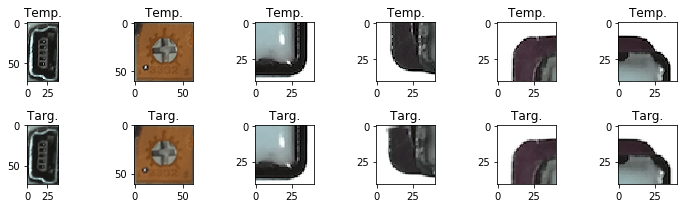

------------------------------------------------------------
Processing "../test_data/switch/test/switch-15-fail.png", be patient...
Image switch-15-fail.png aligned! (correlation=99.422%)
Checking item                                connector... H: 0.99 S: 0.98 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                                  trimmer... H: 0.92 S: 1.00 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       lower right corner... H: 0.33 S: 0.37 V: 0.81 B: 0.86 G: 0.81 R: 0.81
Checking item                        lower left corner... H: 0.99 S: 0.96 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                        upper left corner... H: 0.98 S: 0.98 V: 1.00 B: 1.00 G: 1.00 R: 1.00
Checking item                       upper right corner... H: 0.99 S: 0.95 V: 1.00 B: 1.00 G: 1.00 R: 1.00


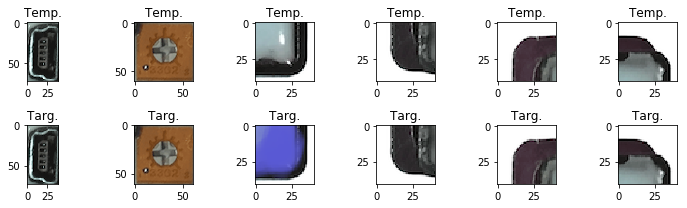

------------------------------------------------------------
DONE!


In [298]:
test_H_points = []
test_S_points = []
test_V_points = []

test_B_points = []
test_G_points = []
test_R_points = []

test_aligned_images = []

# loop over all images in out dataset
for target in images_test:
    print('Processing "%s", be patient...' % target)
    H, S, V, B, G, R, aligned_test_image = process_target(template, target, plot=True, return_aligned=True)
    
    # store results for later...
    test_H_points.append(H)
    test_S_points.append(S)
    test_V_points.append(V)    
    
    test_B_points.append(B)
    test_G_points.append(G)
    test_R_points.append(R)    
        
    test_aligned_images.append(aligned_test_image)
        
print('DONE!')

In [173]:
# save aligned test targes to file for posibble later use 
np.save('test_aligned_images',test_aligned_images)
%ls

aligned_targets.npy                  features_upper left corner.npy
features_BGR_connector.npy           features_upper right corner.npy
features_BGR_lower left corner.npy   labels_connector.npy
features_BGR_lower right corner.npy  labels_lower left corner.npy
features_BGR_trimmer.npy             labels_lower right corner.npy
features_BGR_upper left corner.npy   labels_trimmer.npy
features_BGR_upper right corner.npy  labels_upper left corner.npy
features_connector.npy               labels_upper right corner.npy
features_lower left corner.npy       switch_detector.ipynb
features_lower right corner.npy      switch_detector_component.ipynb
features_trimmer.npy                 test_aligned_images.npy


#### Extract test features

In [311]:
test_features = {}
for k,v in checklist.items():
    # first len(images_oks) are ok in all aspects
    test_features[k] = []

for k,v in checklist.items():
    # first len(images_oks) are ok in all aspects
    for H,S,V,B,G,R in zip(test_H_points,test_S_points,test_V_points,test_B_points,test_G_points,test_R_points):
        test_features[k].append([H[k][0][0],S[k][0][0],V[k][0][0],B[k][0][0],G[k][0][0],R[k][0][0]])

#### Predict labels

In [355]:
pred_test_labels = {}
    
CLASSIFIERS =  classifiers_ADA  # classifiers_MLP # classifiers_GP # classifiers_kNN ## classifiers_NB # classifiers_RANFOR # classifiers_DTREE # classifiers_RANFOR # classifiers_NB # classifiers_DTREE #  # classifiers_ISOFOR # classifiers_ONEC_SVM # classifiers_RANFOR # classifiers_ONEC_SVM  #classifiers_SVM  #classifiers_LSVM
    
for k in CLASSIFIERS.keys():
    pred_test_labels[k] = CLASSIFIERS[k].predict(test_features[k])

In [356]:
pred_test_labels

{'connector': array([1, 1, 0, 1]),
 'lower left corner': array([1, 1, 1, 1]),
 'lower right corner': array([1, 1, 1, 0]),
 'trimmer': array([0, 0, 1, 1]),
 'upper left corner': array([1, 1, 1, 1]),
 'upper right corner': array([1, 1, 1, 1])}

In [357]:
true_test_labels

{'connector': [1, 1, 1, 1],
 'lower left corner': [1, 1, 1, 1],
 'lower right corner': [1, 1, 1, 0],
 'trimmer': [0, 0, 1, 1],
 'upper left corner': [1, 1, 1, 1],
 'upper right corner': [1, 1, 1, 1]}

### Visual evalution of test

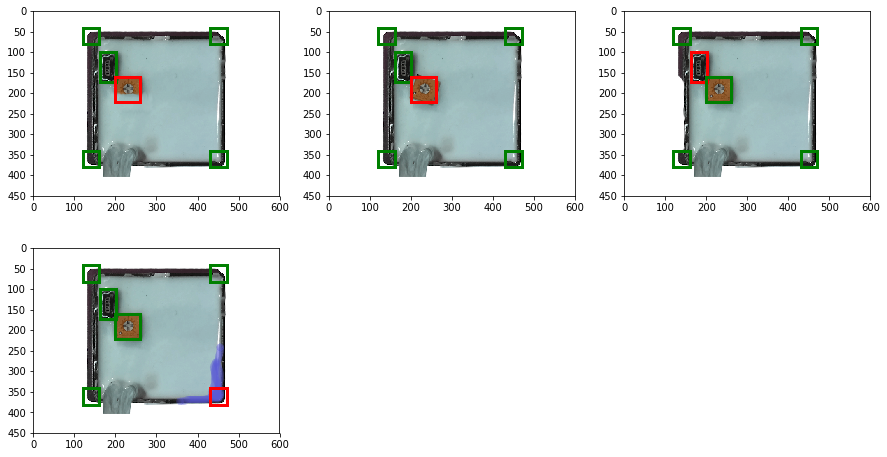

In [358]:
import math
NOT_CLASSIFIED_COLOR = 'b'  # color of bounding box when not classified
CLASSIFIED_OK_COLOR = 'g'  # if checklist item classified as OK
CLASSIFIED_FAIL_COLOR = 'r'

fig = plt.figure(figsize=(15,8))

IMGS_PER_ROW = 3.
    
for i, image in enumerate(images_test):
    test_img = cv2.imread(image)

    class_res = {}
    for k in pred_test_labels.keys():
        class_res[k] = CLASSIFIED_OK_COLOR if pred_test_labels[k][i] == 1 else CLASSIFIED_FAIL_COLOR
    

    ax = fig.add_subplot(math.ceil(len(images_test)/IMGS_PER_ROW),IMGS_PER_ROW,i+1)
    ax.imshow(test_img)
    show_checklist_items(ax, checklist, classification=class_res)